In [1]:
from config import *
from utils import convert_dtypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from plotly.io import show
import optuna

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, learning_curve, validation_curve
from lightgbm import LGBMClassifier

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('bmh')

In [2]:
data_for_train = pd.read_csv(cfg.paths.train_sample).pipe(convert_dtypes)[cfg.training.short_list + ['SK_ID_CURR', 'SAMPLE', 'TARGET']]
train = data_for_train[data_for_train['SAMPLE'] == 'TRAIN'].drop(columns=['SAMPLE'])
oos = data_for_train[data_for_train['SAMPLE'] == 'OOS'].drop(columns=['SAMPLE'])
test = pd.read_csv(cfg.paths.test_sample).pipe(convert_dtypes)[cfg.training.short_list + ['SK_ID_CURR']]

X_train, y_train = train.drop(columns=['TARGET']), train['TARGET']
X_oos, y_oos = oos.drop(columns=['TARGET']), oos['TARGET']

del data_for_train, train, oos

In [3]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.seed)

In [ ]:
def objective_lgbm(trial: optuna.Trial, X, y, cv):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 2000),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1, log=True),       
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False])
    }
    
    auc_scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = LGBMClassifier(
            boosting_type='gbdt', 
            objective='binary', 
            learning_rate=0.05,
            early_stopping_rounds=30,
            verbosity=-1, 
            importance_type='gain', 
            random_state=cfg.seed, 
            **params
        )

        model.fit(
            X_train, y_train,
            eval_metric='auc',
            eval_set=[(X_val, y_val)]
        )
        
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc)

    return np.mean(auc_scores)

In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_lgbm(trial, X_train, y_train, cv=cv), n_trials=200)

[I 2025-08-31 11:39:04,969] A new study created in memory with name: no-name-94583804-41f2-440a-a292-49dd28859fa8
[I 2025-08-31 11:39:23,218] Trial 0 finished with value: 0.7853194746682371 and parameters: {'n_estimators': 474, 'num_leaves': 35, 'min_child_samples': 33, 'colsample_bytree': 0.5236692614765841, 'reg_alpha': 0.002363427114810682, 'reg_lambda': 0.007823381659253493, 'is_unbalance': False}. Best is trial 0 with value: 0.7853194746682371.
[I 2025-08-31 11:39:28,896] Trial 1 finished with value: 0.697387514456363 and parameters: {'n_estimators': 524, 'num_leaves': 45, 'min_child_samples': 1802, 'colsample_bytree': 0.9124543609847819, 'reg_alpha': 0.04307799802857136, 'reg_lambda': 4.823618243256589e-06, 'is_unbalance': True}. Best is trial 0 with value: 0.7853194746682371.
[I 2025-08-31 11:39:34,199] Trial 2 finished with value: 0.6987739072821759 and parameters: {'n_estimators': 239, 'num_leaves': 56, 'min_child_samples': 1827, 'colsample_bytree': 0.7598179248553024, 'reg_al

In [22]:
study.best_params

{'n_estimators': 540,
 'num_leaves': 27,
 'min_child_samples': 1857,
 'colsample_bytree': 0.5002287019819426,
 'reg_alpha': 0.019998333098629646,
 'reg_lambda': 2.6663467952723607e-06,
 'is_unbalance': False}

In [23]:
fig = optuna.visualization.plot_optimization_history(study)
show(fig)

In [24]:
study.trials_dataframe().iloc[[84, 171, 175]]

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_is_unbalance,params_min_child_samples,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,state
84,84,0.787253,2025-08-31 12:04:43.955496,2025-08-31 12:05:04.557202,0 days 00:00:20.601706,0.553276,False,1858,429,31,0.000601,5.502241e-08,COMPLETE
171,171,0.787277,2025-08-31 12:33:27.340081,2025-08-31 12:33:48.608526,0 days 00:00:21.268445,0.500346,False,1809,517,30,0.038987,4.034492e-05,COMPLETE
175,175,0.787320,2025-08-31 12:34:50.400708,2025-08-31 12:35:10.657067,0 days 00:00:20.256359,0.500229,False,1857,540,27,0.019998,2.666347e-06,COMPLETE


In [4]:
best_params = {'n_estimators': 540,
               'num_leaves': 27,
               'min_child_samples': 1857,
               'colsample_bytree': 0.5002287019819426,
               'reg_alpha': 0.019998333098629646, 
               'reg_lambda': 2.6663467952723607e-06,
               'is_unbalance': False}

model = LGBMClassifier(
    boosting_type='gbdt', 
    objective='binary', 
    learning_rate=0.05,
    subsample_freq=1,
    verbosity=-1, 
    importance_type='gain', 
    random_state=cfg.seed, 
    **best_params
)

In [5]:
model.fit(X_train, y_train, eval_metric='auc', eval_set=[(X_oos, y_oos), (X_train, y_train)], eval_names=['valid', 'train'])

LGBMClassifier(colsample_bytree=0.5002287019819426, importance_type='gain',
               is_unbalance=False, learning_rate=0.05, min_child_samples=1857,
               n_estimators=540, num_leaves=27, objective='binary',
               random_state=42, reg_alpha=0.019998333098629646,
               reg_lambda=2.6663467952723607e-06, subsample_freq=1,
               verbosity=-1)

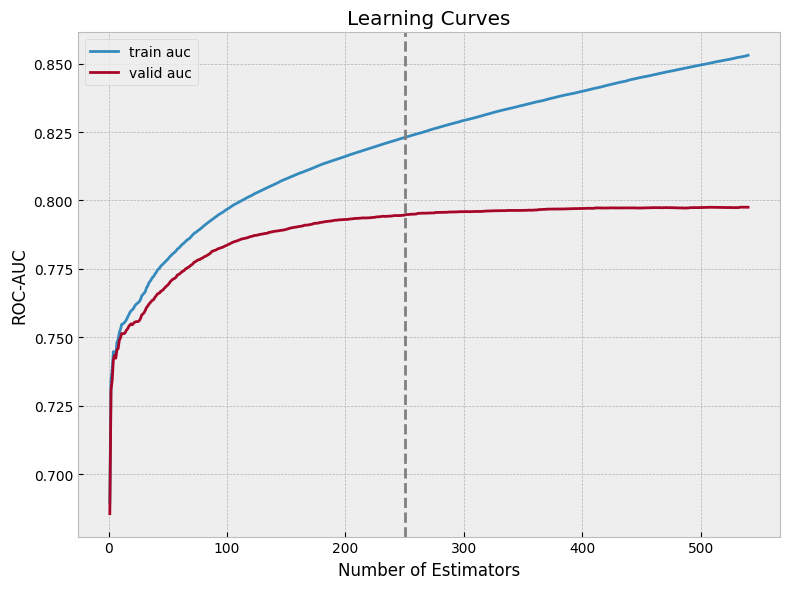

In [6]:
plt.figure(figsize=(8, 6))

train_path = model.evals_result_['train']['auc']
valid_path = model.evals_result_['valid']['auc']
iterations = list(range(1, len(train_path) + 1))

plt.plot(iterations, train_path, label='train auc')
plt.plot(iterations, valid_path, label='valid auc')
plt.axvline(250, color='gray', ls='--')

plt.title('Learning Curves')
plt.xlabel('Number of Estimators')
plt.ylabel('ROC-AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
param = 'subsample'
param_range = [0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

result = validation_curve(model, X_train, y_train, scoring='roc_auc', cv=cv, param_name=param, param_range=param_range, n_jobs=-1)

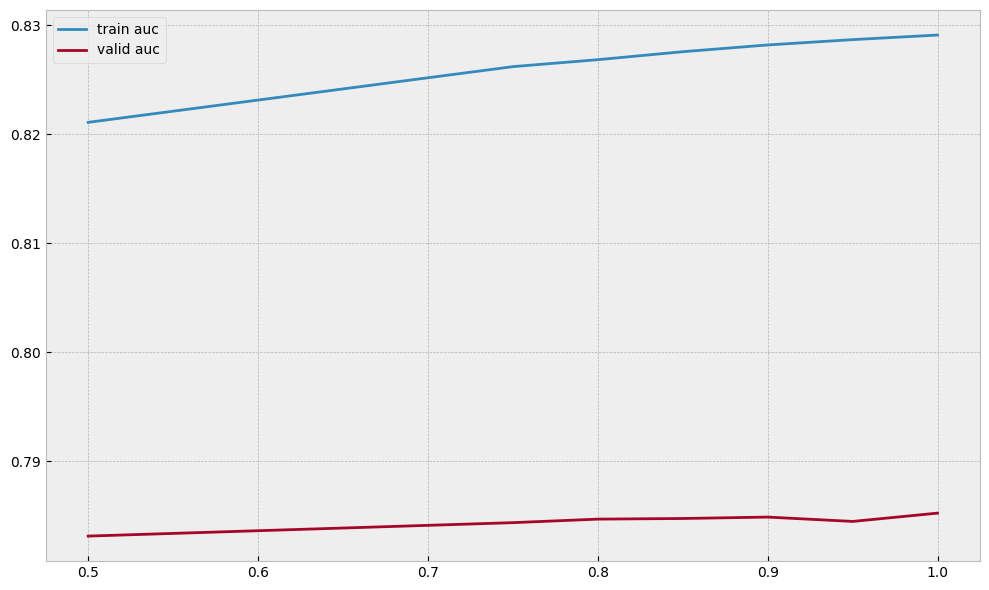

In [33]:
plt.figure(figsize=(10, 6))

plt.plot(param_range, np.mean(result[0], axis=1), label='train auc')
plt.plot(param_range, np.mean(result[1], axis=1), label='valid auc')

plt.legend()
plt.tight_layout()
plt.show()